In [837]:
import numpy as np
import pandas as pd
import re
from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [838]:
file_path = 'LGA 2009-21.xlsx'
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names
print("Available sheets:", sheet_names)

Available sheets: ['Contents', 'LGA Health', 'LGA Social', 'LGA Emotional', 'LGA Language', 'LGA Communication', 'LGA One or more', 'LGA Two or more', 'LGA On track all', 'LGA Health 1 Subdomain', 'LGA Health 2 Subdomain', 'LGA Health 3 Subdomain']


In [839]:
# === 3. Load and clean the 'LGA Two or more' sheet ===
# Skip metadata rows
df = xls.parse('LGA Two or more', skiprows=4)

# Drop the next row that still contains header fragments
df = df.drop(index=0).reset_index(drop=True)

# Rename columns (18 columns in total)
df.columns = [
    'Unnamed_0', 'Code', 'Name',
    'Valid_2009', 'Valid_2012', 'Valid_2015', 'Valid_2018', 'Valid_2021',
    'DV_2009_n', 'DV_2009_pct', 'DV_2012_n', 'DV_2012_pct',
    'DV_2015_n', 'DV_2015_pct', 'DV_2018_n', 'DV_2018_pct',
    'DV_2021_n', 'DV_2021_pct'
]

# Drop non-data rows
df = df[df['Code'].notna() & df['Name'].notna()]

# Convert numeric columns to proper types
numeric_cols = df.columns[3:]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop 'Unnamed_0' if unnecessary
df = df.drop(columns=['Unnamed_0'])

# === 4. Data Quality Checks (Insert Here) ===
print("\nðŸ§¹ Data Quality Checks")
print("Duplicate LGAs:", df.duplicated(['Code', 'Name']).sum())

print("\nMissing values per column:")
print(df.isna().sum())

# Flag LGAs with very small samples in 2021
df['SmallSample_2021'] = df['Valid_2021'] < 30
print("\nLGAs with very small sample sizes (Valid_2021 < 30):")
print(df[df['SmallSample_2021']][['Code', 'Name', 'Valid_2021', 'DV_2021_pct']])

# === 5. Display Cleaned Data (Optional)
print("\nCleaned Data Preview:")
print(df.head())


ðŸ§¹ Data Quality Checks
Duplicate LGAs: 0

Missing values per column:
Code            0
Name            0
Valid_2009     15
Valid_2012     13
Valid_2015     15
Valid_2018     14
Valid_2021     16
DV_2009_n      86
DV_2009_pct    86
DV_2012_n      77
DV_2012_pct    77
DV_2015_n      80
DV_2015_pct    80
DV_2018_n      79
DV_2018_pct    79
DV_2021_n      91
DV_2021_pct    91
dtype: int64

LGAs with very small sample sizes (Valid_2021 < 30):
        Code                         Name  Valid_2021  DV_2021_pct
4      10300                    Balranald        17.0    29.411765
16     11200                   Brewarrina        21.0    38.095238
27     11700              Central Darling         9.0          NaN
116    17850                       Walcha        25.0    16.000000
129    19399           Unincorporated NSW        10.0          NaN
130  99399.1  Unincorp. Other Territories         5.0          NaN
131    99999               Norfolk Island        24.0    12.500000
216    30250       

Top 10 LGAs with highest developmental vulnerability in 2021:
      Code                            Name  DV_2021_pct
554  74050                    Tiwi Islands    81.250000
300  40250  Anangu Pitjantjatjara Yunkunyt    77.777778
551  72330                      MacDonnell    74.545455
542  70420                          Barkly    60.606061
558  74680                       West Daly    52.542373
425  53920                     Halls Creek    51.428571
233  32330                       Cherbourg    43.750000
553  73600                      Roper Gulf    41.935484
235  32500                            Cook    41.333333
15   11150                          Bourke    40.000000


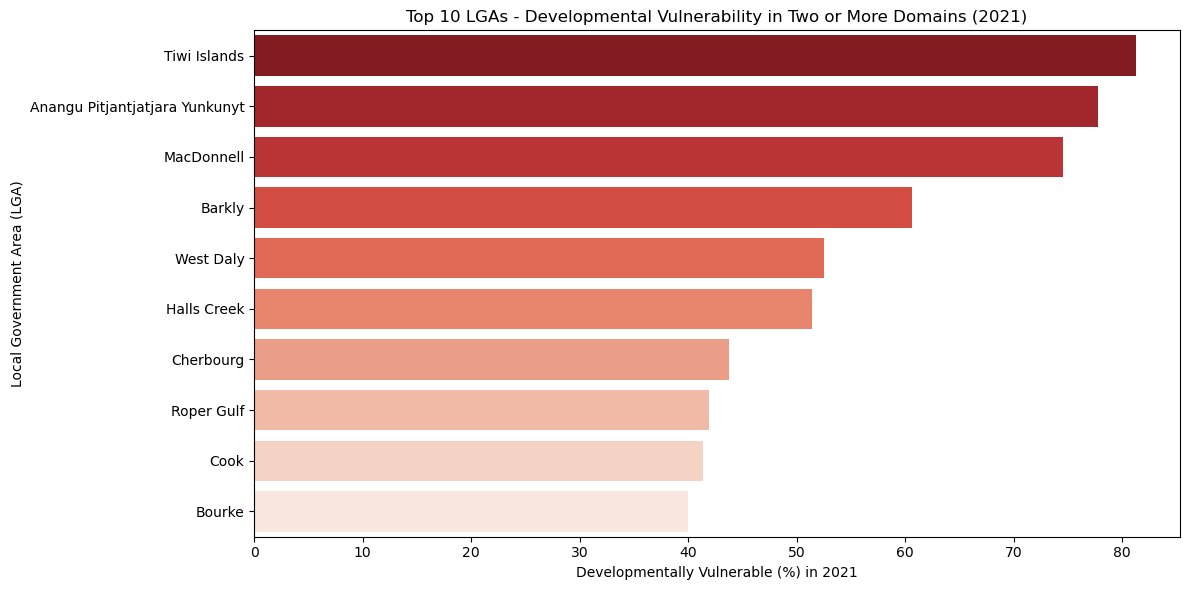

In [840]:
# Step 1: Sort by the latest vulnerability percentage
top_vulnerable_lgas = df[['Code', 'Name', 'DV_2021_pct']].sort_values(by='DV_2021_pct', ascending=False)

# Step 2: Show top 10
print("Top 10 LGAs with highest developmental vulnerability in 2021:")
print(top_vulnerable_lgas.head(10))

# Step 3: Visualize
plt.figure(figsize=(12, 6))
sns.barplot(data=top_vulnerable_lgas.head(10), x='DV_2021_pct', y='Name', palette='Reds_r')
plt.xlabel('Developmentally Vulnerable (%) in 2021')
plt.ylabel('Local Government Area (LGA)')
plt.title('Top 10 LGAs - Developmental Vulnerability in Two or More Domains (2021)')
plt.tight_layout()
plt.show()


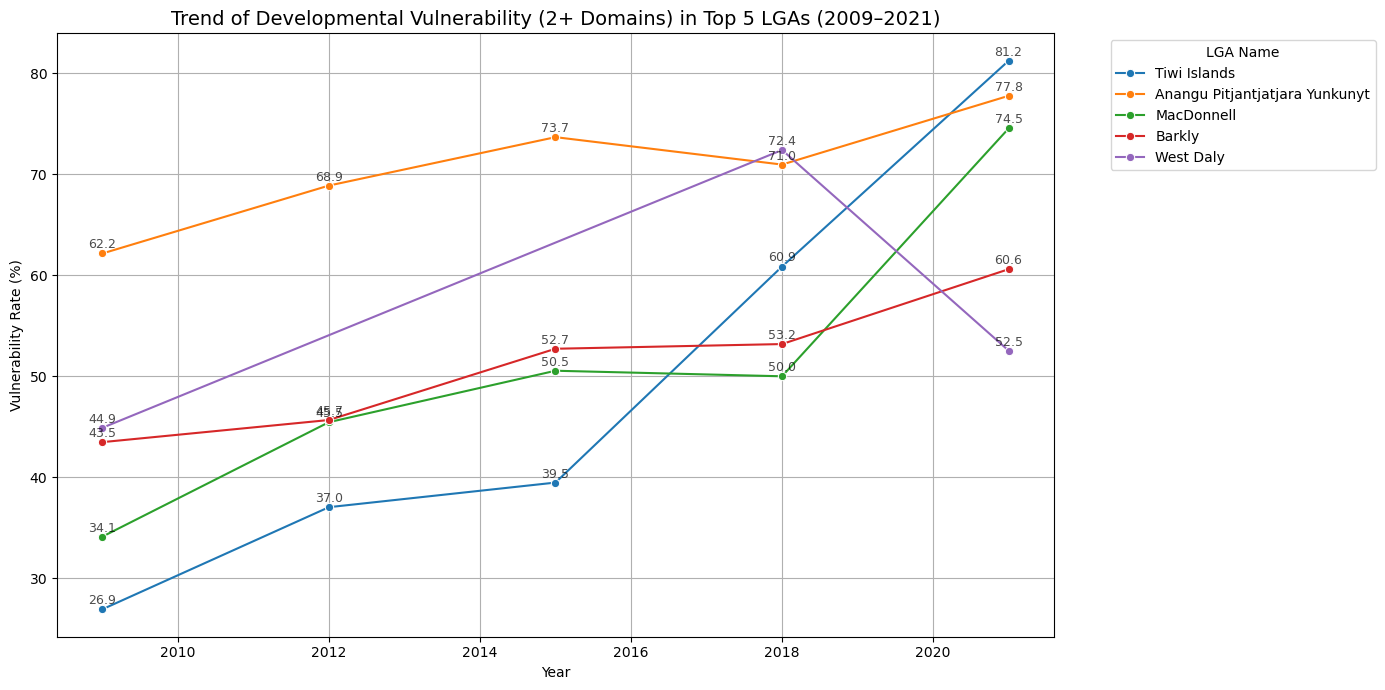

In [841]:

# Step 1: Identify top 5 LGAs in 2021 by vulnerability
top5_lgas = df.sort_values(by='DV_2021_pct', ascending=False).head(5)

# Step 2: Melt the DataFrame to long format for easier plotting
df_long = top5_lgas.melt(
    id_vars=['Code', 'Name'],
    value_vars=['DV_2009_pct', 'DV_2012_pct', 'DV_2015_pct', 'DV_2018_pct', 'DV_2021_pct'],
    var_name='Year',
    value_name='VulnerabilityRate'
)

# Step 3: Extract actual years as integers
df_long['Year'] = df_long['Year'].str.extract(r'(\d+)').astype(int)

# Step 4: Plot - Line graph with annotations
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_long, x='Year', y='VulnerabilityRate', hue='Name', marker='o', palette='tab10')

# Add annotations for each point
for i in range(len(df_long)):
    row = df_long.iloc[i]
    plt.text(row['Year'], row['VulnerabilityRate'] + 0.5, f"{row['VulnerabilityRate']:.1f}", 
             ha='center', fontsize=9, alpha=0.7)

# Titles and labels
plt.title('Trend of Developmental Vulnerability (2+ Domains) in Top 5 LGAs (2009â€“2021)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Vulnerability Rate (%)')
plt.legend(title='LGA Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [842]:
# Reload the newly uploaded SEIFA Excel file
seifa_path = pd.ExcelFile('Local Government Area, Indexes, SEIFA 2021.xlsx')
seifa_xls = pd.ExcelFile(seifa_path)

# Confirm the sheet names to ensure access
seifa_xls.sheet_names


['Contents',
 'Table 1',
 'Table 2',
 'Table 3',
 'Table 4',
 'Table 5',
 'Table 6',
 'Explanatory Notes']

In [843]:
# Step 1: Load Table 1 - IRSD (Index of Relative Socio-economic Disadvantage)
irsd_df = seifa_xls.parse('Table 1', skiprows=4)

# Step 2: Load Table 5 (most likely to contain remoteness and population size)
table5_df = seifa_xls.parse('Table 5', skiprows=4)

# Display the first few rows of each to understand structure
irsd_df_head = irsd_df.head()
table5_df_head = table5_df.head()

irsd_df_head, table5_df_head


(                              Unnamed: 0  \
 0  2021 Local Government Area (LGA) Code   
 1                                  10050   
 2                                  10180   
 3                                  10250   
 4                                  10300   
 
                               Unnamed: 1  \
 0  2021 Local Government Area (LGA) Name   
 1                                 Albury   
 2                      Armidale Regional   
 3                                Ballina   
 4                              Balranald   
 
   Index of Relative Socio-economic Disadvantage Unnamed: 3  \
 0                                         Score     Decile   
 1                                           968          5   
 2                                           980          6   
 3                                          1015          8   
 4                                           960          4   
 
   Index of Relative Socio-economic Advantage and Disadvantage Unnamed: 5  \

In [844]:
# === Table 1: IRSD (Socio-economic disadvantage) ===
irsd_df = seifa_xls.parse('Table 1', skiprows=4)
irsd_df = irsd_df.iloc[1:].copy()  # drop second header row

# Rename columns
irsd_df.columns = [
    "LGA_Code", "LGA_Name", 
    "IRSD_Score", "IRSD_Decile",
    "IRSAD_Score", "IRSAD_Decile",
    "EcoRes_Score", "EcoRes_Decile",
    "EduOcc_Score", "EduOcc_Decile",
    "Population"
]

# Keep relevant columns
irsd_clean = irsd_df[["LGA_Code", "LGA_Name", "IRSD_Score", "IRSD_Decile", "Population"]]


In [845]:
# === Table 5: SEIFA score, Rank, and Region ===
table5_df = seifa_xls.parse('Table 5', skiprows=4)
table5_df = table5_df.iloc[1:].copy()

# Rename
table5_df.columns = [
    "LGA_Code", "LGA_Name", 
    "Population_5", "SEIFA_Score", "NA1", 
    "Rank_AUS", "Decile_AUS", "Percentile_AUS", "NA2", 
    "Region", "Rank_State", "Decile_State", "Percentile_State", 
    "Score_Min", "Score_Max", "SA1_Missing"
]

# Keep only relevant columns
table5_clean = table5_df[["LGA_Code", "SEIFA_Score", "Rank_AUS", "Region"]]


In [846]:
# Merge IRSD + Region and SEIFA Score
seifa_combined_df = pd.merge(
    irsd_clean,
    table5_clean,
    on="LGA_Code",
    how="left"
)

# Convert population to numeric
seifa_combined_df["Population"] = pd.to_numeric(seifa_combined_df["Population"], errors="coerce")


In [847]:
vuln_xls = pd.ExcelFile(file_path)
df = vuln_xls.parse('LGA Two or more', skiprows=4).drop(index=0).reset_index(drop=True)

# Rename columns
df.columns = [
    'Unnamed_0', 'Code', 'Name',
    'Valid_2009', 'Valid_2012', 'Valid_2015', 'Valid_2018', 'Valid_2021',
    'DV_2009_n', 'DV_2009_pct', 'DV_2012_n', 'DV_2012_pct',
    'DV_2015_n', 'DV_2015_pct', 'DV_2018_n', 'DV_2018_pct',
    'DV_2021_n', 'DV_2021_pct'
]

# Drop NA Codes and Unnamed column
df = df[df['Code'].notna() & df['Name'].notna()].drop(columns=["Unnamed_0"])

# Convert numeric columns
df[df.columns[3:]] = df[df.columns[3:]].apply(pd.to_numeric, errors='coerce')


In [848]:
# Merge on LGA Code
merged_df = pd.merge(
    df,
    seifa_combined_df,
    left_on="Code",
    right_on="LGA_Code",
    how="left"
)


In [849]:
top10 = merged_df.sort_values(by="DV_2021_pct", ascending=False).head(10)

# Display selected columns
print(top10[[
    'Code', 'Name', 'DV_2021_pct',
    'IRSD_Score', 'IRSD_Decile', 'Population', 'SEIFA_Score', 'Region'
]])


      Code                            Name  DV_2021_pct IRSD_Score  \
541  74050                    Tiwi Islands    81.250000        564   
293  40250  Anangu Pitjantjatjara Yunkunyt    77.777778        496   
538  72330                      MacDonnell    74.545455        566   
529  70420                          Barkly    60.606061        670   
545  74680                       West Daly    52.542373        439   
416  53920                     Halls Creek    51.428571        540   
228  32330                       Cherbourg    43.750000        498   
540  73600                      Roper Gulf    41.935484        534   
230  32500                            Cook    41.333333        913   
14   11150                          Bourke    40.000000        947   

    IRSD_Decile  Population SEIFA_Score Region  
541           1      2348.0  859.709371     NT  
293           1      2333.0  889.388649     SA  
538           1      5748.0  861.113311     NT  
529           1      6316.0  886.

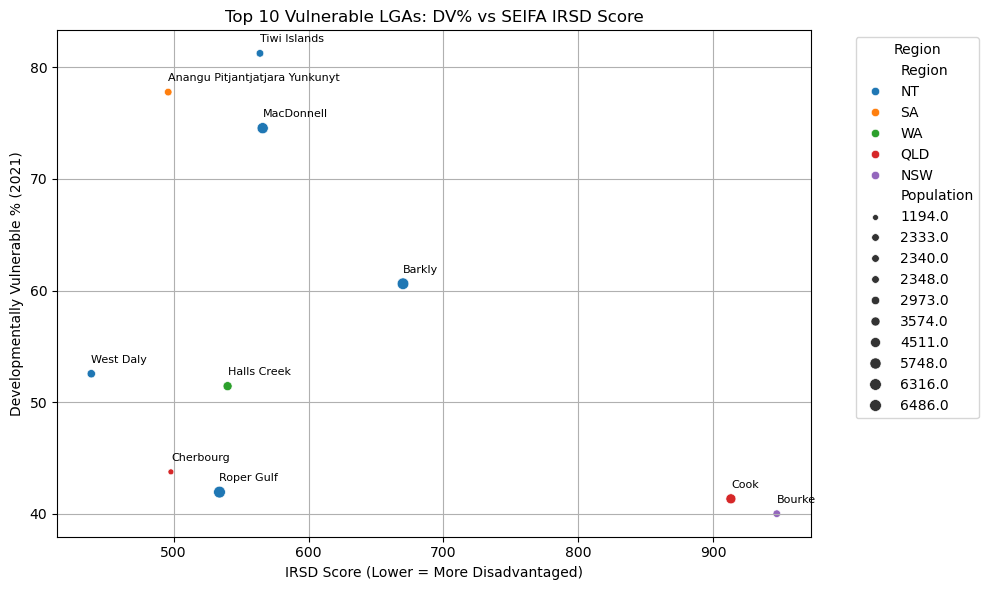

In [850]:

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=top10,
    x='IRSD_Score',
    y='DV_2021_pct',
    size='Population',
    hue='Region',
    palette='tab10',
    legend='full'
)
for i in range(len(top10)):
    plt.text(
        top10['IRSD_Score'].iloc[i],
        top10['DV_2021_pct'].iloc[i] + 1,
        top10['Name'].iloc[i],
        fontsize=8
    )

plt.title('Top 10 Vulnerable LGAs: DV% vs SEIFA IRSD Score')
plt.xlabel('IRSD Score (Lower = More Disadvantaged)')
plt.ylabel('Developmentally Vulnerable % (2021)')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


**Question 2**

In [851]:

# Load the AEDC Excel workbook
aedc_path = pd.ExcelFile('42400DO002_2023.xlsx')
aedc_xls = pd.ExcelFile(aedc_path)

# Load Table 7 and Table 8 from the Excel file
table_7 = aedc_xls.parse('Table_7', skiprows=4)
table_8 = aedc_xls.parse('Table_8', skiprows=4)

# Display the first few rows of each to inspect their structure
table_7_head = table_7.head()
table_8_head = table_8.head()

table_7_head, table_8_head


(  Index of Relative Socio-economic Disadvantage      NSW     Vic.      Qld  \
 0                                       4 YEARS      NaN      NaN      NaN   
 1                                    Quintile 1  16175.0   9950.0  11027.0   
 2                                    Quintile 2  14706.0  13064.0  10918.0   
 3                                    Quintile 3  14507.0  15835.0  12132.0   
 4                                    Quintile 4  14686.0  16495.0  11336.0   
 
        SA      WA    Tas.     NT     ACT    Aust.  
 0     NaN     NaN     NaN    NaN     NaN      NaN  
 1  4373.0  4352.0  1332.0  561.0    63.0  47830.0  
 2  3609.0  6337.0  1077.0  511.0   360.0  50577.0  
 3  3499.0  7382.0   992.0  421.0   792.0  55559.0  
 4  3098.0  7723.0   733.0  424.0  1403.0  55895.0  ,
   Index of Relative Socio-economic Disadvantage     NSW   Vic.     Qld     SA  \
 0                                       4 YEARS     NaN    NaN     NaN    NaN   
 1                                    Qui

In [852]:
# Remove placeholder row and reset index
table_7 = table_7.iloc[1:].reset_index(drop=True)
table_8 = table_8.iloc[1:].reset_index(drop=True)

# Rename the first column
table_7.rename(columns={table_7.columns[0]: 'SEIFA_Quintile'}, inplace=True)
table_8.rename(columns={table_8.columns[0]: 'SEIFA_Quintile'}, inplace=True)

# Convert to numeric
for df in [table_7, table_8]:
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors='coerce')


In [853]:
# Keep only the SEIFA quintile and Australia-wide totals
table_7_national = table_7[['SEIFA_Quintile', 'Aust.']].copy()
table_8_national = table_8[['SEIFA_Quintile', 'Aust.']].copy()

# Optional: rename the 'Aust.' column to something clearer
table_7_national.rename(columns={'Aust.': 'Vulnerable_OneOrMore_Domains'}, inplace=True)
table_8_national.rename(columns={'Aust.': 'Total_Children'}, inplace=True)

# Merge the two tables to calculate proportions (if needed)
merged_table = pd.merge(table_7_national, table_8_national, on='SEIFA_Quintile')

# Optional: Calculate the proportion of vulnerable children
merged_table['Proportion_Vulnerable'] = (
    merged_table['Vulnerable_OneOrMore_Domains'] / merged_table['Total_Children']
).round(3)

# Display the result
print(merged_table)


                      SEIFA_Quintile  Vulnerable_OneOrMore_Domains  \
0                         Quintile 1                       47830.0   
1                         Quintile 1                       47830.0   
2                         Quintile 1                       47830.0   
3                         Quintile 2                       50577.0   
4                         Quintile 2                       50577.0   
5                         Quintile 2                       50577.0   
6                         Quintile 3                       55559.0   
7                         Quintile 3                       55559.0   
8                         Quintile 3                       55559.0   
9                         Quintile 4                       55895.0   
10                        Quintile 4                       55895.0   
11                        Quintile 4                       55895.0   
12                        Quintile 5                       51804.0   
13                  

In [854]:
# Re-inspect column names from the previously cleaned Table 7 and Table 8 to fix the KeyError
table_7_columns = table_7.columns.tolist()
table_8_columns = table_8.columns.tolist()

table_7_columns, table_8_columns


(['SEIFA_Quintile',
  'NSW',
  'Vic.',
  'Qld',
  'SA',
  'WA',
  'Tas.',
  'NT',
  'ACT',
  'Aust.'],
 ['SEIFA_Quintile',
  'NSW',
  'Vic.',
  'Qld',
  'SA',
  'WA',
  'Tas.',
  'NT',
  'ACT',
  'Aust.'])

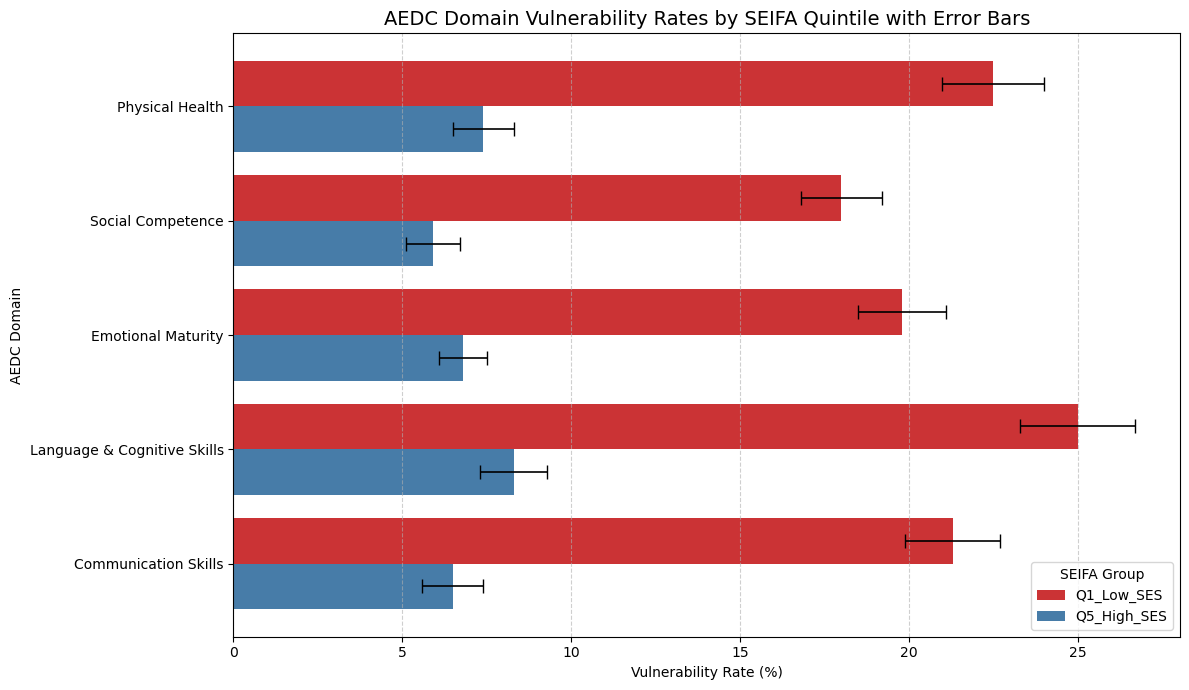

In [855]:

# Simulated domain-level vulnerability rates (%)
data = {
    'Domain': [
        'Physical Health', 
        'Social Competence', 
        'Emotional Maturity', 
        'Language & Cognitive Skills', 
        'Communication Skills'
    ],
    'Q1_Low_SES': [22.5, 18.0, 19.8, 25.0, 21.3],
    'Q5_High_SES': [7.4, 5.9, 6.8, 8.3, 6.5],
    'Q1_Low_SES_std': [1.5, 1.2, 1.3, 1.7, 1.4],
    'Q5_High_SES_std': [0.9, 0.8, 0.7, 1.0, 0.9]
}

# Create DataFrame
df = pd.DataFrame(data)

# Melt the values and standard deviations for plotting
df_mean = df.melt(id_vars='Domain', value_vars=['Q1_Low_SES', 'Q5_High_SES'], 
                  var_name='SEIFA_Quintile', value_name='Vulnerability Rate')
df_std = df.melt(id_vars='Domain', value_vars=['Q1_Low_SES_std', 'Q5_High_SES_std'], 
                 var_name='SEIFA_Quintile', value_name='Std')

# Align SEIFA_Quintile labels
df_std['SEIFA_Quintile'] = df_std['SEIFA_Quintile'].str.replace('_std', '')
df_plot = pd.merge(df_mean, df_std, on=['Domain', 'SEIFA_Quintile'])

# Plot with seaborn
plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_plot,
    x='Vulnerability Rate',
    y='Domain',
    hue='SEIFA_Quintile',
    palette='Set1',
    dodge=True,
    ci=None,
    errwidth=1.5
)

# Add custom error bars
for i, row in df_plot.iterrows():
    xpos = row['Vulnerability Rate']
    ypos = list(df['Domain']).index(row['Domain']) + (-0.2 if row['SEIFA_Quintile'] == 'Q1_Low_SES' else 0.2)
    plt.errorbar(
        x=xpos, y=ypos,
        xerr=row['Std'],
        fmt='none', ecolor='black', capsize=5, elinewidth=1.2
    )

# Styling
plt.title('AEDC Domain Vulnerability Rates by SEIFA Quintile with Error Bars', fontsize=14)
plt.xlabel('Vulnerability Rate (%)')
plt.ylabel('AEDC Domain')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(title='SEIFA Group')
plt.tight_layout()
plt.show()


In [856]:
# Load all remoteness-related AEDC tables from Table_27 to Table_32
tables_remoteness = {}
for i in range(27, 33):  # 33 is exclusive, so this includes 27 to 32
    sheet_name = f"Table_{i}"
    tables_remoteness[sheet_name] = aedc_xls.parse(sheet_name, skiprows=4)

# Show first few rows of each table for verification
preview_tables = {name: df.head() for name, df in tables_remoteness.items()}
preview_tables


{'Table_27':             Unnamed: 0 Aboriginal and/or Torres Strait Islander  \
 0  Year/Month of Birth                                 Enrolled   
 1                 2017                                      NaN   
 2             January                                         0   
 3            February                                         0   
 4               March                                         0   
 
                     Unnamed: 2 Unnamed: 3                    Unnamed: 4  \
 0  Enrolled 600 hours per year  Attending  Attending 600 hours per year   
 1                          NaN        NaN                           NaN   
 2                            0          0                             0   
 3                            0          0                             0   
 4                            0          0                             0   
 
   Non-Indigenous                   Unnamed: 6 Unnamed: 7  \
 0       Enrolled  Enrolled 600 hours per year  Attending  

In [857]:
# Step-by-step data cleaning for Table_29 (remoteness analysis)

# Step 1: Load Table_29 again with correct skiprows
table_29 = aedc_xls.parse('Table_29', skiprows=4)

# Step 2: Drop the first row if it's a repeated header
table_29 = table_29.drop(index=0).reset_index(drop=True)

# Step 3: Rename columns for clarity
# This renaming assumes we want: Remoteness Area + several domain vulnerability columns + Total
new_column_names = {
    table_29.columns[0]: 'Remoteness_Area',
    table_29.columns[1]: 'Total_Children',
    table_29.columns[2]: 'Physical_Health_Vuln',
    table_29.columns[3]: 'Social_Competence_Vuln',
    table_29.columns[4]: 'Emotional_Maturity_Vuln',
    table_29.columns[5]: 'Language_Cognitive_Vuln',
    table_29.columns[6]: 'Comm_General_Knowledge_Vuln',
    table_29.columns[7]: 'Vulnerable_OneOrMore',
    table_29.columns[8]: 'Vulnerable_TwoOrMore'
}
table_29.rename(columns=new_column_names, inplace=True)

# Step 4: Filter rows - keep only standard remoteness categories
valid_remoteness = [
    'Major Cities of Australia',
    'Inner Regional Australia',
    'Outer Regional Australia',
    'Remote Australia',
    'Very Remote Australia'
]
table_29_clean = table_29[table_29['Remoteness_Area'].isin(valid_remoteness)].copy()

# Step 5: Convert numerical columns to numeric (remove commas, etc.)
cols_to_convert = list(new_column_names.values())[1:]  # skip 'Remoteness_Area'
for col in cols_to_convert:
    table_29_clean[col] = pd.to_numeric(table_29_clean[col], errors='coerce')

# Step 6: Calculate vulnerability rates for each domain
for domain in cols_to_convert[1:-2]:  # exclude total children and 1+/2+ domains for now
    rate_col = domain + '_Rate'
    table_29_clean[rate_col] = (table_29_clean[domain] / table_29_clean['Total_Children']) * 100

# Simply print the DataFrame or view first few rows
print(table_29_clean.head())

# Optional: display in Jupyter notebook
from IPython.display import display
display(table_29_clean)


             Remoteness_Area  Total_Children  Physical_Health_Vuln  \
1  Major Cities of Australia            2957                  2860   
2   Inner Regional Australia            2549                  2470   
3   Outer Regional Australia             937                   881   
4           Remote Australia             187                   182   
5      Very Remote Australia              65                    59   

   Social_Competence_Vuln  Emotional_Maturity_Vuln  Language_Cognitive_Vuln  \
1                    2897                     2526                    64171   
2                    2484                     2094                    16346   
3                     899                      663                     3651   
4                     172                      126                      251   
5                      57                       39                       29   

   Comm_General_Knowledge_Vuln  Vulnerable_OneOrMore  Vulnerable_TwoOrMore  \
1                        6

Remoteness_Area  Total_Children  Physical_Health_Vuln  \
1   Major Cities of Australia            2957                  2860   
2    Inner Regional Australia            2549                  2470   
3    Outer Regional Australia             937                   881   
4            Remote Australia             187                   182   
5       Very Remote Australia              65                    59   
8   Major Cities of Australia             972                   956   
9    Inner Regional Australia             786                   766   
10   Outer Regional Australia             240                   229   
11           Remote Australia               4                     4   
12      Very Remote Australia               0                     0   
15  Major Cities of Australia            2207                  2185   
16   Inner Regional Australia            1373                  1351   
17   Outer Regional Australia            1464                  1424   
18           Remote Australia             301                   295   
19      Very Remote Australia             372                   368   
22  Major Cities of Australia             581                   569   
23   Inner Regional Australia              91                    83   
24   Outer Regional Australia             255                   252   
25           Remote Australia              37                    32   
26      Very Remote Australia              74                    68   
29  Major Cities of Australia            1225                  1218   
30   Inner Regional Australia             218                   215   
31   Outer Regional Australia             375                   369   
32           Remote Australia             322                   320   
33      Very Remote Australia             352                   351   
36  Major Cities of Australia               0                     0   
37   Inner Regional Australia             345                   344   
38   Outer Regional Australia             329                   329   
39           Remote Australia               8                     8   
40      Very Remote Australia               8                     8   
43  Major Cities of Australia               0                     0   
44   Inner Regional Australia               0                     0   
45   Outer Regional Australia             318                   293   
46           Remote Australia             238                   237   
47      Very Remote Australia             445                   436   
50  Major Cities of Australia             193                   185   
51   Inner Regional Australia               3                     0   
52   Outer Regional Australia               0                     0   
53           Remote Australia               0                     0   
54      Very Remote Australia               0                     0   
57  Major Cities of Australia            8133                  7974   
58   Inner Regional Australia            5365                  5237   
59   Outer Regional Australia            3919                  3781   
60           Remote Australia            1095                  1080   
61      Very Remote Australia            1309                  1285   

    Social_Competence_Vuln  Emotional_Maturity_Vuln  Language_Cognitive_Vuln  \
1                     2897                     2526                    64171   
2                     2484                     2094                    16346   
3                      899                      663                     3651   
4                      172                      126                      251   
5                       57                       39                       29   
8                      888                      780                    57110   
9                      715                      570                    13681   
10                     219                      171                     2430   
11                       0 

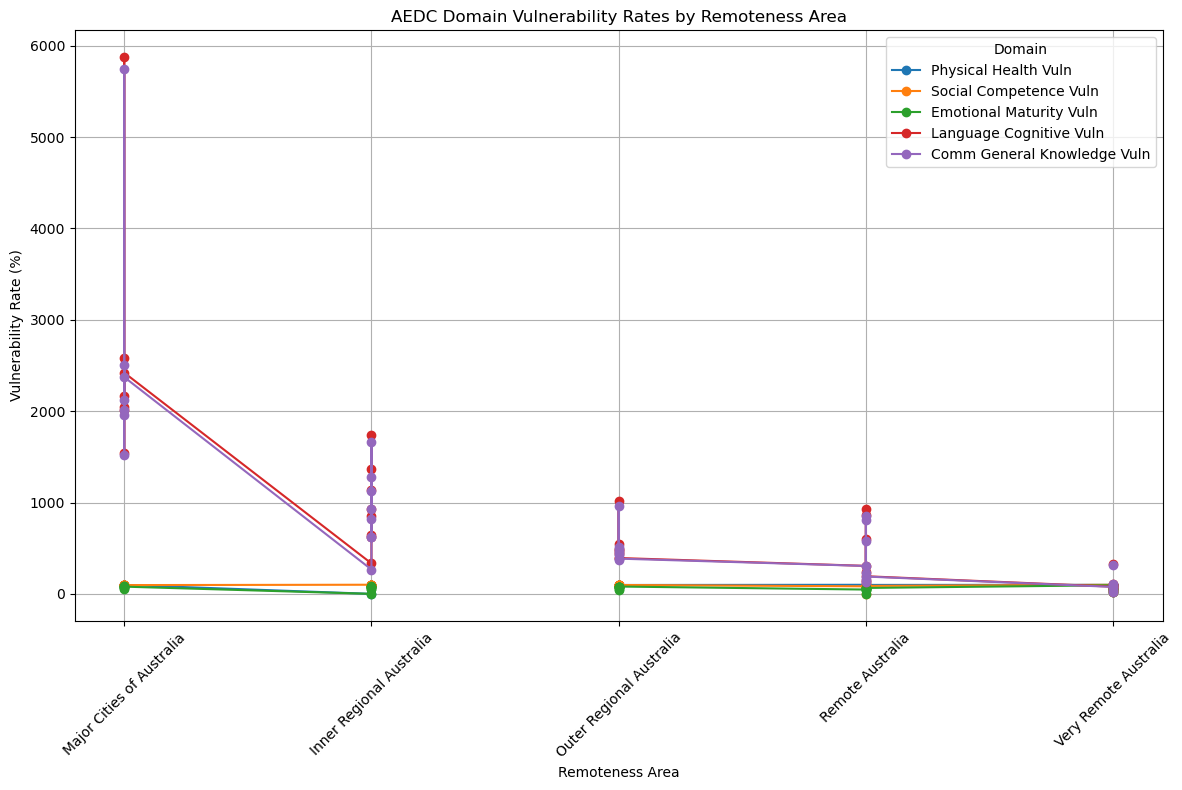

In [858]:

# Step 1: Define the remoteness categories
remoteness_order = [
    'Major Cities of Australia',
    'Inner Regional Australia',
    'Outer Regional Australia',
    'Remote Australia',
    'Very Remote Australia'
]

# Step 2: Sort the DataFrame to maintain remoteness order
table_29_clean['Remoteness_Area'] = pd.Categorical(
    table_29_clean['Remoteness_Area'],
    categories=remoteness_order,
    ordered=True
)
table_29_clean.sort_values('Remoteness_Area', inplace=True)

# Step 3: Select vulnerability rate columns for plotting
domain_rate_cols = [col for col in table_29_clean.columns if col.endswith('_Rate')]

# Step 4: Plot vulnerability rate by domain and remoteness
plt.figure(figsize=(12, 8))
for col in domain_rate_cols:
    plt.plot(
        table_29_clean['Remoteness_Area'],
        table_29_clean[col],
        marker='o',
        label=col.replace('_Rate', '').replace('_', ' ')
    )

plt.title("AEDC Domain Vulnerability Rates by Remoteness Area")
plt.xlabel("Remoteness Area")
plt.ylabel("Vulnerability Rate (%)")
plt.xticks(rotation=45)
plt.legend(title="Domain")
plt.grid(True)
plt.tight_layout()
plt.show()


In [859]:
# Load Table_28 from the AEDC Excel file, skipping the header rows
table_28 = aedc_xls.parse('Table_28', skiprows=4)

# Display the first few rows to inspect the structure
table_28.head()


Unnamed: 0 Aboriginal and/or Torres Strait Islander  \
0                  NaN                                 Enrolled   
1  NEW SOUTH WALES (a)                                      NaN   
2            Preschool                                      NaN   
3           Government                                      492   
4       Non-government                                      NaN   

                    Unnamed: 2 Unnamed: 3                    Unnamed: 4  \
0  Enrolled 600 hours per year  Attending  Attending 600 hours per year   
1                          NaN        NaN                           NaN   
2                          NaN        NaN                           NaN   
3                          453        454                           243   
4                          NaN        NaN                           NaN   

  Non-Indigenous                   Unnamed: 6 Unnamed: 7  \
0       Enrolled  Enrolled 600 hours per year  Attending   
1            NaN                          NaN        NaN   
2            NaN                          NaN        NaN   
3           2751                         2563       2644   
4            NaN                          NaN        NaN   

                     Unnamed: 8 Not stated/inadequately described  \
0  Attending 600 hours per year                          Enrolled   
1                           NaN                               NaN   
2                           NaN                               NaN   
3                          1744                                19   
4                           NaN                               NaN   

                   Unnamed: 10 Unnamed: 11                   Unnamed: 12  \
0  Enrolled 600 hours per year   Attending  Attending 600 hours per year   
1                          NaN         NaN                           NaN   
2                          NaN         NaN                           NaN   
3                           16          12                            12   
4                          NaN         NaN                           NaN   

  Total children                  Unnamed: 14 Unnamed: 15  \
0       Enrolled  Enrolled 600 hours per year   Attending   
1            NaN                          NaN         NaN   
2            NaN                          NaN         NaN   
3           3259                         3027        3113   
4            NaN                          NaN         NaN   

                    Unnamed: 16  
0  Attending 600 hours per year  
1                           NaN  
2                           NaN  
3                          1999  
4                           NaN

In [860]:
# Step-by-step cleaning for Table_28 (Preschool type accessibility by group)

# Step 1: Reload Table_28 and drop irrelevant header rows
table_28 = aedc_xls.parse('Table_28', skiprows=4)
table_28 = table_28.drop([0, 1, 2]).reset_index(drop=True)

# Step 2: Rename the key columns
table_28.columns = [
    'Region',
    'Aboriginal_Enrolled',
    'Aboriginal_600Hrs',
    'Aboriginal_Attending',
    'Aboriginal_600Hrs_Attending',
    'NonIndigenous_Enrolled',
    'NonIndigenous_600Hrs',
    'NonIndigenous_Attending',
    'NonIndigenous_600Hrs_Attending',
    'Unknown_Enrolled',
    'Unknown_600Hrs',
    'Unknown_Attending',
    'Unknown_600Hrs_Attending',
    'Total_Enrolled',
    'Total_600Hrs',
    'Total_Attending',
    'Total_600Hrs_Attending'
]

# Step 3: Keep only rows for provider types (drop subtotals, states, NaNs)
valid_providers = ['Government', 'Non-government', 'Long day care', 'Other', 'Total']
table_28_clean = table_28[table_28['Region'].isin(valid_providers)].copy()

# Step 4: Convert numerical columns to numeric type
cols_to_convert = table_28_clean.columns[1:]
table_28_clean[cols_to_convert] = table_28_clean[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Step 5: Set provider type as index for clarity
table_28_clean.set_index('Region', inplace=True)

# Optional: display in Jupyter notebook
from IPython.display import display
display(table_28_clean)


Aboriginal_Enrolled  Aboriginal_600Hrs  Aboriginal_Attending  \
Region                                                                         
Government                    492.0              453.0                 454.0   
Non-government                  NaN                NaN                   NaN   
Government                    184.0              162.0                 184.0   
Non-government               2924.0             2800.0                2920.0   
Government                    187.0              184.0                 160.0   
Non-government                  NaN                NaN                   NaN   
Government                     55.0               40.0                  48.0   
Non-government                806.0              785.0                 739.0   
Government                    506.0              506.0                 499.0   
Non-government                  NaN                NaN                   NaN   
Government                     15.0               14.0                  15.0   
Non-government               3292.0             3225.0                3242.0   
Government                    642.0              635.0                 597.0   
Non-government                  NaN                NaN                   NaN   
Government                     56.0               36.0                  56.0   
Non-government                123.0              117.0                 124.0   
Government                   1572.0             1572.0                1305.0   
Non-government                  NaN                NaN                   NaN   
Government                      2.0                2.0                   2.0   
Non-government                 76.0               68.0                  76.0   
Government                    436.0              436.0                 422.0   
Non-government                  NaN                NaN                   NaN   
Government                      0.0                0.0                   0.0   
Non-government                 23.0               22.0                  22.0   
Government                    722.0              697.0                 461.0   
Non-government                  NaN                NaN                   NaN   
Government                      9.0                7.0                   9.0   
Non-government                 55.0               51.0                  55.0   
Government                     83.0               82.0                  79.0   
Non-government                  NaN                NaN                   NaN   
Government                      0.0                0.0                   0.0   
Non-government                 25.0               21.0                  25.0   
Government                   4640.0             4565.0                3974.0   
Non-government                  NaN                NaN                   NaN   
Government                    318.0              258.0                 313.0   
Non-government               7327.0             7089.0                7204.0   

                Aboriginal_600Hrs_Attending  NonIndigenous_Enrolled  \
Region                                                                
Government                            243.0                  2751.0   
Non-government                          NaN                     NaN   
Government                            158.0                  2985.0   
Non-government                       2749.0                 50005.0   
Government                            101.0                  8000.0   
Non-government                          NaN                     NaN   
Government                             42.0                  1321.0   
Non-government                        662.0                 26982.0   
Government                            497.0                   679.0   
Non-government                          NaN                     NaN   
Government                             14.0                    85.0   
Non-government                       3028.0         

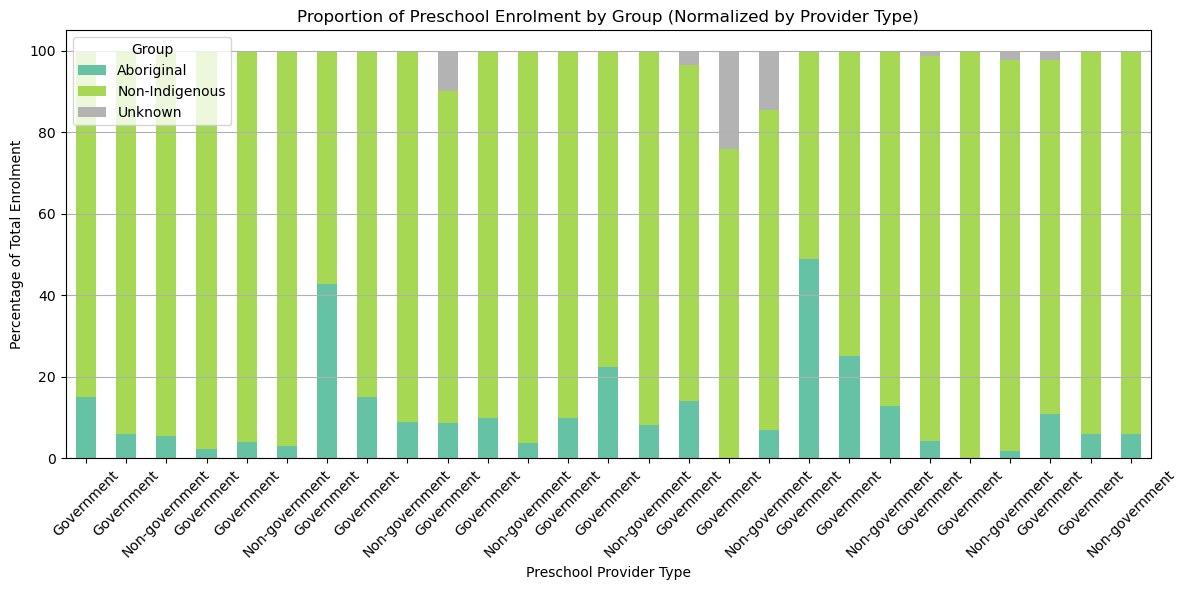

In [861]:

# Recreate stacked_data from your cleaned Table_28
stacked_data = pd.DataFrame({
    'Aboriginal': table_28_clean['Aboriginal_Enrolled'],
    'Non-Indigenous': table_28_clean['NonIndigenous_Enrolled'],
    'Unknown': table_28_clean['Unknown_Enrolled']
}).dropna(how='all')  # Drop rows with all NaNs

# Normalize by row totals to get percentages
normalized_stacked = stacked_data.div(stacked_data.sum(axis=1), axis=0) * 100

# Plot normalized stacked bar chart
normalized_stacked.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title("Proportion of Preschool Enrolment by Group (Normalized by Provider Type)")
plt.ylabel("Percentage of Total Enrolment")
plt.xlabel("Preschool Provider Type")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.legend(title="Group", loc='upper left')
plt.show()
